In [1]:
! pip install langchain langchain-openai langchain-community langgraph python-dotenv faiss-cpu pypdf

   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
    --------------------------------------- 0.3/18.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/18.7 MB 2.1 MB/s eta 0:00:09
   -- ------------------------------------- 1.0/18.7 MB 2.3 MB/s eta 0:00:08
   --- ------------------------------------ 1.8/18.7 MB 2.5 MB/s eta 0:00:07
   ---- ----------------------------------- 2.1/18.7 MB 2.4 MB/s eta 0:00:07
   ------ --------------------------------- 2.9/18.7 MB 2.5 MB/s eta 0:00:07
   -------- ------------------------------- 3.9/18.7 MB 2.9 MB/s eta 0:00:06
   ---------- ----------------------------- 5.0/18.7 MB 3.2 MB/s eta 0:00:05
   ------------- -------------------------- 6.3/18.7 MB 3.5 MB/s eta 0:00:04
   -------------- ------------------------- 6.8/18.7 MB 3.6 MB/s eta 0:00:04
   ----------------- ---------------------- 8.1/18.7 MB 3.7 MB/s eta 0:00:03
   -------------------- ------------------- 9.4/18.7 MB 3.9 MB/s eta 0:00:03
   ----------

In [3]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [4]:
load_dotenv()

True

In [5]:
llm = ChatOpenAI(model='gpt-4o-mini')

In [7]:
loader = PyPDFLoader("intro-to-ml.pdf")
docs = loader.load()

In [8]:
len(docs)

441

In [9]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [10]:
len(chunks)

1307

In [11]:
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
vector_store = FAISS.from_documents(chunks, embeddings)

In [12]:
vector_store

In [13]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [14]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [15]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [16]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [17]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [18]:
tool_node = ToolNode(tools)

In [19]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

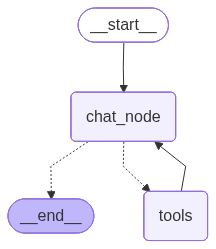

In [21]:
chatbot

In [20]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

c:\Users\Lenovo\anaconda3\envs\amar\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


In [22]:
print(result['messages'][-1].content)

To find the ideal value of \( K \) in K-Nearest Neighbors (KNN), it's important to understand the trade-off between bias and variance that occurs with different values of \( K \):

1. **Bias-Variance Trade-off**:
   - A **small value of \( K \)** (e.g., \( K = 1 \)) results in a very flexible model. This can capture a lot of nuances in the training data, leading to **low bias**. However, it also introduces **high variance**, meaning the model is sensitive to noise in the training data and may not generalize well to unseen data.
   - A **large value of \( K \)** (e.g., \( K = 100 \)) smooths out the predictions over many points, which reduces variance but can lead to **high bias**. This smoothing may mask some underlying structures in the data.

2. **Choosing the Optimal \( K \)**:
   - The optimal value of \( K \) is found through experimentation. One common approach is to evaluate the model's performance using cross-validation. This involves:
     - Splitting the dataset into training